## Question
A retail chain in the India wants to use Traindata source to build an efficient forecasting model to predict the sales SKU  wise in its portfolio at its 76 different stores using historical sales Traindata for the past 3 years on a week-on-week basis. Sales and promotional seasonality is also available for each week -SKU and store wise. However, no other information regarding stores and products are available. Can you still forecast accurately the sales values for every such product/SKU-store combination for the next 12 weeks accurately?

Use python to predict the SKU wise Product wise sales
Prepare a summary of results, issue faced and what are steps taken 
Submit results with code as a git repo with a detailed readme file

### Import Libraries

In [133]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import sklearn
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf 
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense

import warnings 
warnings.filterwarnings('ignore')

### Loading Traindata

In [134]:
dataSetRetail = pd.read_csv('./data/DataSetRetail.csv')
dataSetRetail.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku
0,212645,16-07-2013,8091,216418,108.3000,108.3000,0,0
1,212646,16-07-2013,8091,216419,109.0125,109.0125,0,0
2,212647,16-07-2013,8091,216425,133.9500,133.9500,0,0
3,212648,16-07-2013,8091,216233,133.9500,133.9500,0,0
4,212649,16-07-2013,8091,217390,176.7000,176.7000,0,0


In [135]:
Traindata = pd.read_csv('./data/Traindata.csv')
Traindata.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17-01-2011,8091,216418,99.0375,111.8625,0,0,20
1,2,17-01-2011,8091,216419,99.0375,99.0375,0,0,28
2,3,17-01-2011,8091,216425,133.9500,133.9500,0,0,19
3,4,17-01-2011,8091,216233,133.9500,133.9500,0,0,44
4,5,17-01-2011,8091,217390,141.0750,141.0750,0,0,52


In [136]:
len(dataSetRetail) , len(Traindata)

(13860, 150150)

We observe the following columns:

* record_ID: An identifier for each record.
* week: The week of sales Traindata.
* store_id: Identifier for the store.
* sku_id: Identifier for the SKU.
* total_price: The total price for the SKU.
* base_price: The base price for the SKU.
* is_featured_sku: Indicator if the SKU was featured that week (1 if yes, 0 otherwise).
* is_display_sku: Indicator if the SKU was on display that week (1 if yes, 0 otherwise).
* units_sold: The number of units sold.

### Exploratory Data Analysis

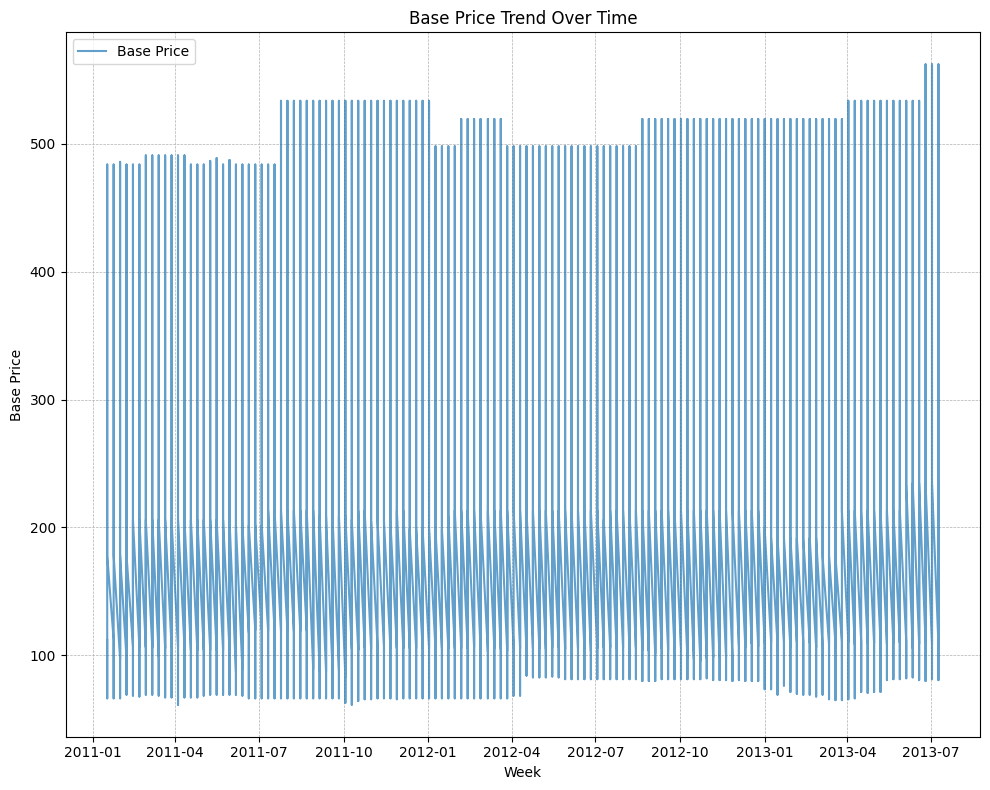

In [137]:
Traindata['week'] = pd.to_datetime(Traindata['week'], format = '%d-%m-%Y')

plt.figure(figsize = (10 , 8))
plt.plot(Traindata['week'], Traindata['base_price'], label = 'Base Price', alpha = 0.7)
plt.title('Base Price Trend Over Time')
plt.xlabel('Week')
plt.ylabel("Base Price")
plt.legend()
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
plt.tight_layout()
plt.show()

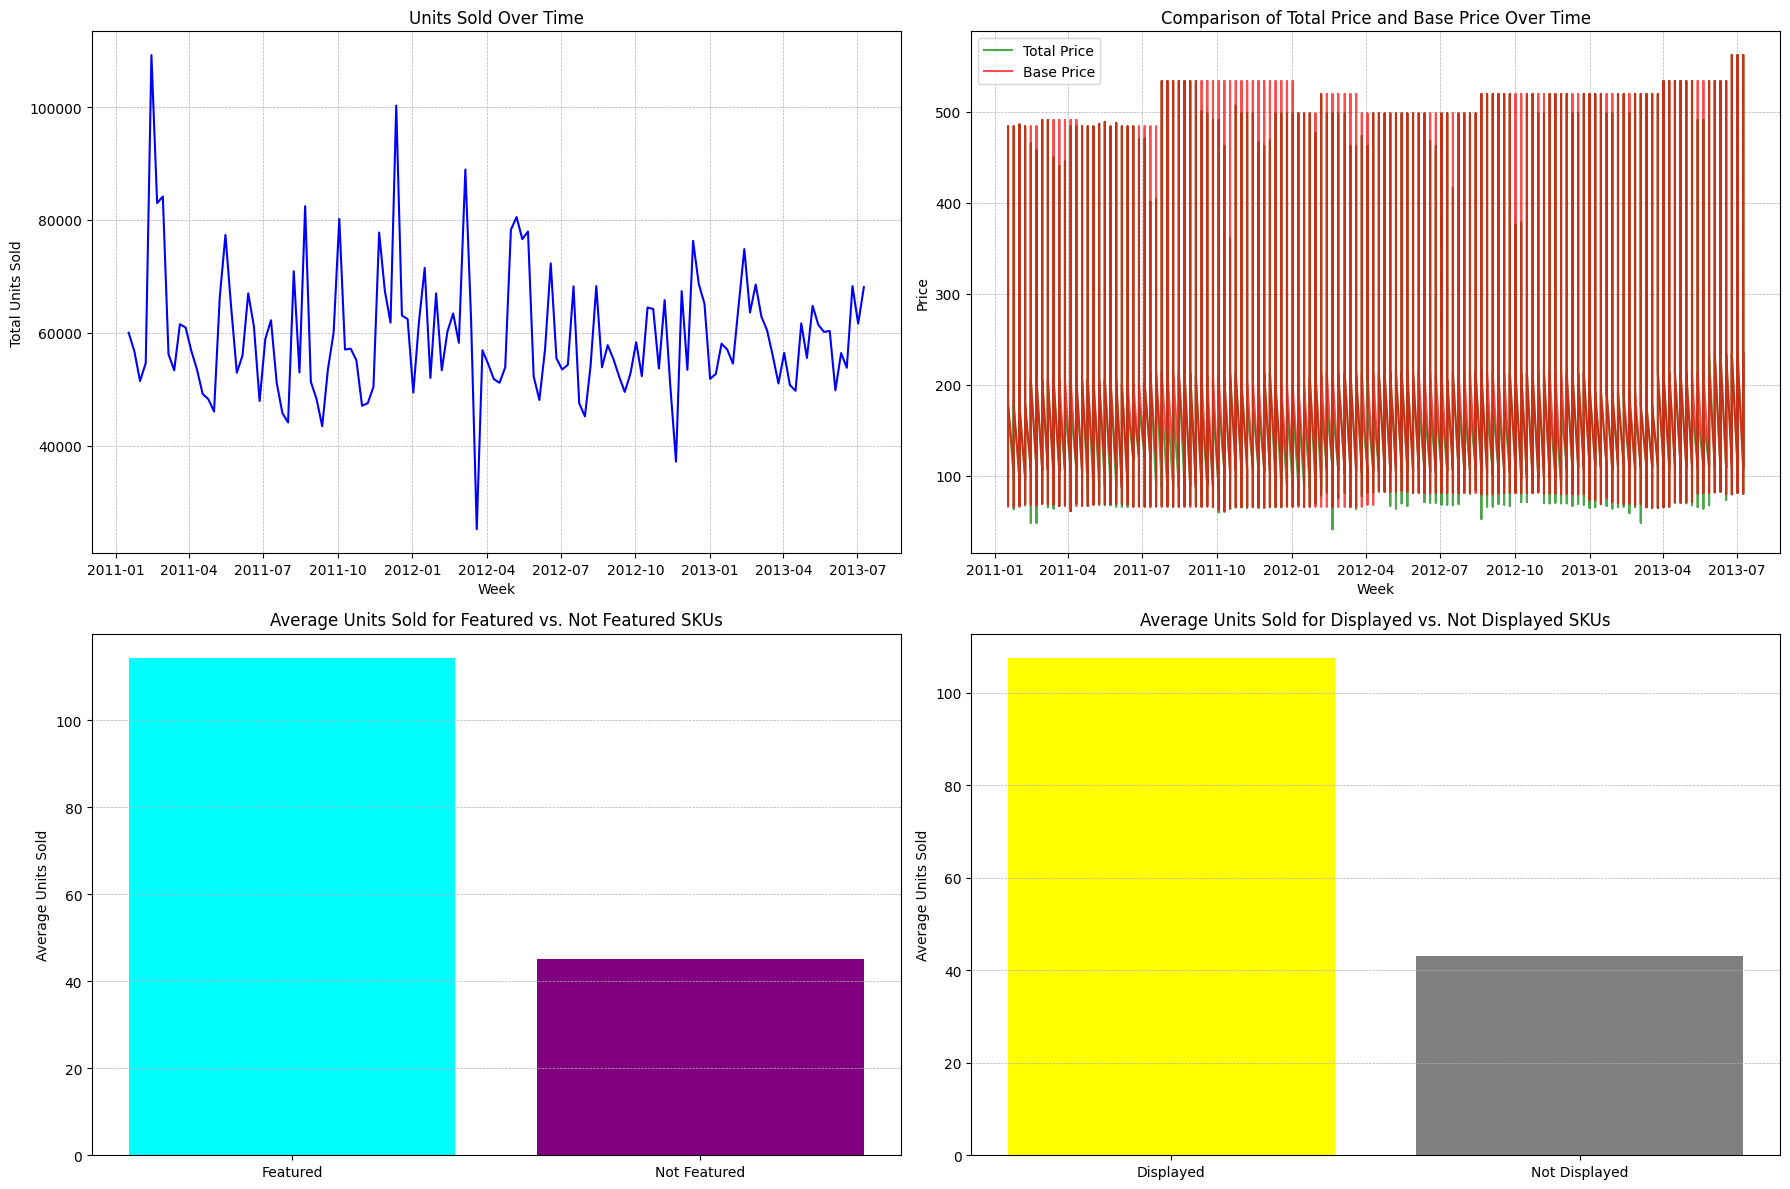

In [138]:
fig, axs = plt.subplots(2, 2, figsize = (18, 12))

# 1. Units Sold Over Time
axs[0, 0].plot(Traindata.groupby('week')['units_sold'].sum(), label='Units Sold', color='blue')
axs[0, 0].set_title('Units Sold Over Time')
axs[0, 0].set_xlabel('Week')
axs[0, 0].set_ylabel('Total Units Sold')
axs[0, 0].grid(True, which='both', linestyle='--', linewidth=0.5)

# 2. Comparison of Total Price and Base Price
axs[0, 1].plot(Traindata['week'], Traindata['total_price'], label='Total Price', color='green', alpha=0.7)
axs[0, 1].plot(Traindata['week'], Traindata['base_price'], label='Base Price', color='red', alpha=0.7)
axs[0, 1].set_title('Comparison of Total Price and Base Price Over Time')
axs[0, 1].set_xlabel('Week')
axs[0, 1].set_ylabel('Price')
axs[0, 1].legend()
axs[0, 1].grid(True, which='both', linestyle='--', linewidth=0.5)

# 3. Effect of Featured or Displayed SKUs on Units Sold
featured_sales = Traindata[Traindata['is_featured_sku'] == 1]['units_sold'].mean()
non_featured_sales = Traindata[Traindata['is_featured_sku'] == 0]['units_sold'].mean()
display_sales = Traindata[Traindata['is_display_sku'] == 1]['units_sold'].mean()
non_display_sales = Traindata[Traindata['is_display_sku'] == 0]['units_sold'].mean()


axs[1, 0].bar(['Featured', 'Not Featured'], [featured_sales, non_featured_sales], color=['cyan', 'purple'])
axs[1, 0].set_title('Average Units Sold for Featured vs. Not Featured SKUs')
axs[1, 0].set_ylabel('Average Units Sold')
axs[1, 0].grid(axis='y', linestyle='--', linewidth=0.5)

axs[1, 1].bar(['Displayed', 'Not Displayed'], [display_sales, non_display_sales], color=['yellow', 'gray'])
axs[1, 1].set_title('Average Units Sold for Displayed vs. Not Displayed SKUs')
axs[1, 1].set_ylabel('Average Units Sold')
axs[1, 1].grid(axis='y', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


## Data Preprocessing
1. Convert the 'week' column to a datatime format 
2. Check for missing values
3. Look at the distribution of target variable `units_sold`
4. Prepare the data for training the forecasting model

In [139]:
# Convert 'week' column to datetime format
Traindata['week'] = pd.to_datetime(Traindata['week'], format = '%d-%m-%Y')

# Check for missing values
missing_values = Traindata.isnull().sum()

# Display missing values and summary statistics for 'units_sold'
missing_values, Traindata['units_sold'].describe()

(record_ID          0
 week               0
 store_id           0
 sku_id             0
 total_price        1
 base_price         0
 is_featured_sku    0
 is_display_sku     0
 units_sold         0
 dtype: int64,
 count    150150.000000
 mean         51.674206
 std          60.207904
 min           1.000000
 25%          20.000000
 50%          35.000000
 75%          62.000000
 max        2876.000000
 Name: units_sold, dtype: float64)

Observations
1. The `week` column has been successfully converted to a datetime format.
2. There is no missing value in the `total_price` column.
3. The target variable, `units_sold`, has a wide range of values, with the minimum being 1 and maximum being 
2,876. The average number of units sold is approximately 51.67.      

### Handling Missing data

In [140]:
Traindata['total_price'].fillna(Traindata['total_price'].median(), inplace = True)

missing_values_updated = Traindata.isnull().sum()
missing_values_updated

record_ID          0
week               0
store_id           0
sku_id             0
total_price        0
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

### Feature Engineering 
We can create some additional features:
1. `Price Difference`: The difference betweenn the base price and the total price. This can help the effect of discounts on sales.
2. `Year`: To capture any year-on-year trends.

In [141]:
Traindata['Year'] = Traindata['week'].dt.year
Traindata['price_difference'] = Traindata['base_price'] - Traindata['total_price']

Traindata.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,Year,price_difference
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20,2011,12.825
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28,2011,0.000
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19,2011,0.000
3,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44,2011,0.000
4,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52,2011,0.000


### Model Training and Prediction

In [142]:
from datetime import timedelta

# Split the data into training and validation sets
# Define the cutoff date for the last 12 weeks
cutoff_date = Traindata['week'].max() - timedelta(weeks = 12)

train_data = Traindata[Traindata['week'] <= cutoff_date]
val_data = Traindata[Traindata['week'] > cutoff_date]

# Split the features and target variable
X_train = train_data.drop(['record_ID', 'week', 'units_sold'], axis=1)
y_train = train_data['units_sold']

X_val = val_data.drop(['record_ID', 'week', 'units_sold'], axis=1)
y_val = val_data['units_sold']

X_train.shape, X_val.shape

((136290, 8), (13860, 8))

In [143]:
HORIZON = 1 
WINDOW_SIZE = 12

In [144]:
# Split the features and target variable
X_train = train_data.drop(['record_ID', 'week', 'units_sold'], axis=1)
y_train = train_data['units_sold']

X_val = val_data.drop(['record_ID', 'week', 'units_sold'], axis=1)
y_val = val_data['units_sold']


# Data preprocessing
def transform_series(series, window_size):
    """Convert a time series into a supervised learning dataset."""
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

# Parameters
window_size = 12  # Use past 12 weeks to predict the next week

# Extract and normalize the sample series
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_series = scaler.fit_transform(Traindata['base_price'].values.reshape(-1, 1))

# Convert series to supervised learning format
X, y = transform_series(scaled_series, window_size)

# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data into training and validation (last 24 weeks for validation)
train_size = len(X) - 24
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

X_train.shape, y_train.shape


((150114, 12, 1), (150114, 1))

In [145]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_val)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_val)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, valid_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 12, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 12, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>)

In [146]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss='mse')
model.fit(train_dataset, epochs = 50, batch_size = 1024, validation_data = valid_dataset)

# Forecasting
forecast = []
current_batch = scaled_series[-window_size:]
for i in range(12):
    predicted_value = model.predict(current_batch.reshape(1, window_size, 1))[0][0]
    forecast.append(predicted_value)
    current_batch = np.append(current_batch[1:], predicted_value)

# Inverse transform the forecast
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))


Epoch 1/50
147/147 [==============================] - 3s 16ms/step - loss: 0.0526 - val_loss: 0.0414
Epoch 2/50
147/147 [==============================] - 2s 16ms/step - loss: 0.0380 - val_loss: 0.0343
Epoch 3/50
147/147 [==============================] - 2s 15ms/step - loss: 0.0359 - val_loss: 0.0340
Epoch 4/50
147/147 [==============================] - 2s 13ms/step - loss: 0.0357 - val_loss: 0.0335
Epoch 5/50
147/147 [==============================] - 2s 13ms/step - loss: 0.0353 - val_loss: 0.0326
Epoch 6/50
147/147 [==============================] - 2s 14ms/step - loss: 0.0346 - val_loss: 0.0309
Epoch 7/50
147/147 [==============================] - 2s 14ms/step - loss: 0.0337 - val_loss: 0.0289
Epoch 8/50
147/147 [==============================] - 2s 13ms/step - loss: 0.0330 - val_loss: 0.0279
Epoch 9/50
147/147 [==============================] - 2s 14ms/step - loss: 0.0325 - val_loss: 0.0275
Epoch 10/50
147/147 [==============================] - 2s 13ms/step - loss: 0.0317 - val_lo

In [147]:
forecast

array([[165.26884],
       [154.11789],
       [169.67984],
       [189.25282],
       [206.2919 ],
       [317.90393],
       [319.65344],
       [247.35707],
       [282.81046],
       [360.69305],
       [129.69444],
       [157.15831]], dtype=float32)

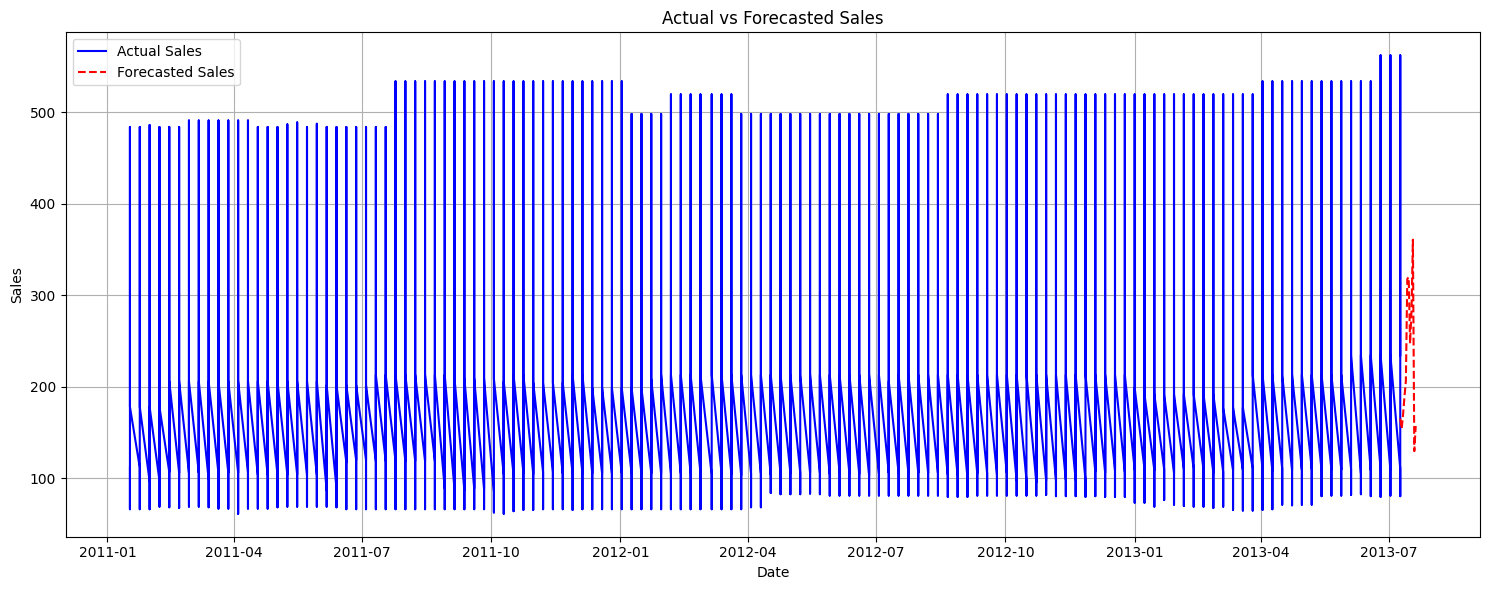

In [148]:
dates = Traindata['week'].values

# Generate dates for the forecasted period
forecast_dates = pd.date_range(dates[-1], periods = 12).values

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(dates, Traindata['base_price'], label='Actual Sales', color='blue')
plt.plot(forecast_dates, forecast.flatten(), label='Forecasted Sales', color='red', linestyle='--')
plt.title('Actual vs Forecasted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
